In [1]:
import numpy as np
from matplotlib import pyplot as plt

from lib import Loads

In [2]:
solid1 = Loads.execute("data/entrada.xls")

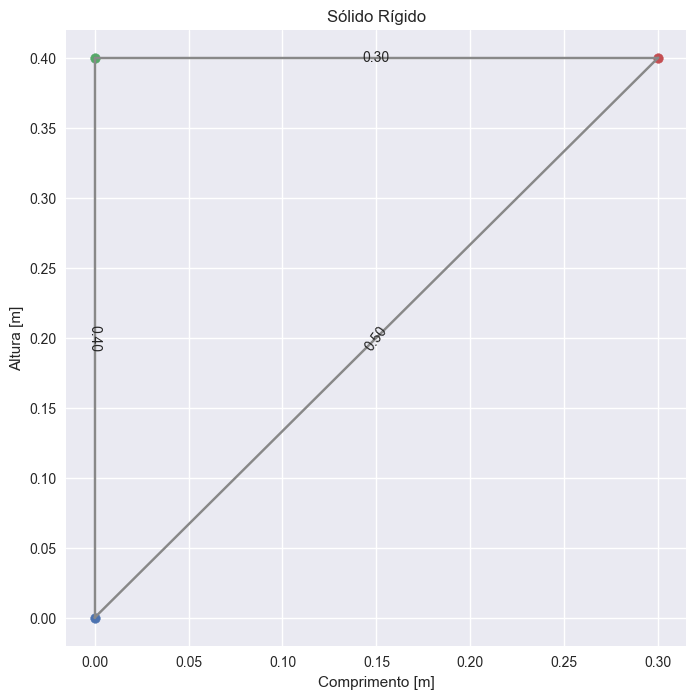

In [3]:
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(8, 8))

plt.title("Sólido Rígido")
plt.xlabel("Comprimento [m]")
plt.ylabel("Altura [m]")
solid1.plot()
plt.show()

In [4]:
K = solid1.rigidity
K

array([[ 3.0240e+07,  4.0320e+07, -3.0240e+07, -4.0320e+07,  0.0000e+00,
         0.0000e+00],
       [ 4.0320e+07,  2.9876e+08, -2.8532e+08, -5.3760e+07,  0.0000e+00,
         0.0000e+00],
       [-3.0240e+07, -2.8532e+08,  2.7524e+08,  4.0320e+07,  0.0000e+00,
         0.0000e+00],
       [-4.0320e+07, -5.3760e+07,  4.0320e+07,  5.3760e+07,  0.0000e+00,
         0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00]])

In [5]:
# K_1 = np.linalg.inv(K)
# K_1

In [6]:
for node in solid1.nodes:
    print(node.displacement)

[False, False]
[False, True]
[True, True]


In [8]:
for beam in solid1.beams:
    print(beam.tension)

210000000000.0
210000000000.0
210000000000.0
